# Example 1: Hupsel Brook model

This is the cases study #1 from the chapter 12 of the SWAP manual. This notebook aims to present the way the model is created in pySWAP package. It goes through the process of setting up the model, running the model and plotting the Epot results.

## 1. Setting up the model

For each major section of the main swp file, there is a class in pySWAP that needs to be created. Then, all the objects are collected into the main Model class that is responsible for running the model and capturing the results. Some auxiliary files like .crp have their own class objects that need to be created and attached to the main class for the section.

### Metadata and Simulation Settings

In [2]:
from pyswap.core.metadata import Metadata
from pyswap.core.simsettings import SimSettings

meta = Metadata(author="John Doe",
                institution="University of Somewhere",
                email="john.doe@somewhere.com",
                project="pySWAP test - hupsel brook",
                swap_ver="4.2")

inlist_csv = ['rain', 'irrig', 'interc', 'runoff', 'drainage',
                'dstor', 'epot', 'eact', 'tpot', 'tact', 'qbottom', 'gwl']

simset = SimSettings(
    tstart='2002-01-01',
    tend='2004-12-31',
    nprintday=1,
    swmonth=1,
    swyrvar=0,
    datefix='2004-12-31',
    swvap=1,
    swblc=1,
    swsba=1,
    swinc=1,
    swcsv=1,
    inlist_csv=['watbal']
)

### Meteorological settings

For the meteorological section, there are three class objects: 
- PenmanMoteith - in case you want to use P-M method for Evap, the settings are stored there
- MeteorologicalData - this holds the precipitation data
- Meteorology - the main class object for the meteorological settings

In [3]:
from pyswap.atmosphere.meteorology import Meteorology, MeteorologicalData, PenmanMonteith


pen_mon = PenmanMonteith(
    alt=10.0,
    altw=10.0,
    angstroma=0.25,
    angstromb=0.5,
)

meteo_data = MeteorologicalData()
meteo_data.weather_kmni(station='283')

meteo = Meteorology(
    metfil='283.met',
    lat=52.0,
    swetr=0,
    file_meteo=meteo_data,
    penman_monteith=pen_mon,
    swdivide=1,
    swmetdetail=0
)

### Crop settings

Here I have taken the easy way: just opening ready .crp files and saving them further down the lines to the directory where SWAP is executer. However, the .crp files should also be prepared separately, very much the same way the .swp file is prepared. This is presented in a separate notebook.

#### Creating the maize crp file
The CropFile has an option to either open a predefined file from a path, or create a file the same way as a swp file. Below is an example of creating a file for maize.

In [4]:
from pyswap.plant.createcrop.preparation import Preparation
from pyswap.plant.createcrop.cropdev import (OxygenStress, DroughtStress, 
                                       SaltStress, CompensateRWUStress,
                                       Interception)
from pyswap.plant.createcrop.irrigation import ScheduledIrrigation
from pyswap.plant.crop import CropFile
from pyswap.plant.createcrop.cropdev import CropDevelopmentSettings
from pandas import DataFrame

prep = Preparation(
    swprep=0,
    swsow=0,
    swgerm=0,
    dvsend=3.0,
    swharv=0
)
# Not present in the WOFOST dataset
df_dvs_lai = DataFrame({
        'dvs': [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0],
        'lai': [0.05, 0.14, 0.61, 4.10, 5.00, 5.80, 5.20]
    })
# Not present in the WOFOST dataset
df_dvs_ch = DataFrame({
    'dvs': [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0],
    'ch': [1.0, 15.0, 40.0, 140.0, 170.0, 180.0, 175.0]
})

df_dvs_rd = DataFrame({
    'dvs': [0.0, 0.3, 0.5, 0.7, 1.0, 2.0],
    'rd': [5.0, 20.0, 50.0, 80.0, 90.0, 100.0]
})

df_rrd_rdens = DataFrame({
    'rrd': [0.0, 1.0],
    'rdens': [1.0, 0.0]
})

cropdev_settings = CropDevelopmentSettings(
    idev=1,
    lcc=168,
    kdif=0.6,
    kdir=0.75,
    swgc=1,
    gctb=df_dvs_lai,
    swcf=2,
    table_dvs_ch=df_dvs_ch,
    albedo=0.23,
    rsc=61.0,
    rsw=0.0,
    swrd=1,
    rdtb=df_dvs_rd,
    rdctb=df_rrd_rdens
)


ox_stress = OxygenStress(
    swoxygen=1,
    swwrtnonox=0,
    aeratecrit=0.5,
    hlim1=-15.0,
    hlim2u=-30.0,
    hlim2l=-30.0,
)

dr_stress = DroughtStress(
    swdrought=1,
    hlim3h = -325.0,
    hlim3l = -600.0,
    hlim4 = -8000.0,
    adcrh = 0.5,
    adcrl = 0.1,
    )

salt_stress = SaltStress(
    swsalinity=0
)

rwu_comp = CompensateRWUStress(
    swcompensate=0
)

interception = Interception(
    swinter=1,
    cofab=0.25
)


schedule = ScheduledIrrigation(
    schedule=0
)


crpmaize = CropFile(
    name='maizes',
    prep=prep,
    cropdev_settings=cropdev_settings,
    oxygenstress=ox_stress,
    droughtstress=dr_stress,
    saltstress=salt_stress,
    compensaterwu=rwu_comp,
    interception=interception,
    scheduledirrigation=schedule
)

##### Creating the crop file for maize from the WOFOST database


Parameters that overlap between the SWAP-WOFOST and the WOFOST crop files:
{IN SWAP -> IN WOFOST if different}
IDSL
TSUMEA -> TSUM1
TSUMAM -> TSUM2
DTSMTB
? -> DVSI (Initial development stage = 0.0)
? -> DVSEND (development stage at harvest = 2.0)
VERNBASE
VERNSAT
VERNDVS
VERNRTB
TDWI
RGRLAI
LAIEM -> ? (Leaf area index at emergence)
SPA
SSA -> SSATB (Specific stem area, it's a table in WOFOST but a value in SWAP)
SPAN
TBASE
SLATB

#### creating the Crop object

In [5]:
from pyswap.plant.crop import Crop, CropFile
from pandas import DataFrame
from datetime import date as dt

croprotation = DataFrame({'cropstart': [dt(2002, 5, 1), dt(2003, 5, 10), dt(2004, 1, 1)],
                          'cropend': [dt(2002, 10, 15), dt(2003, 9, 29), dt(2004, 12, 31)],
                          'cropfil': ["'maizes'", "'potatod'", "'grassd'"],
                          'croptype': [1, 2, 3]})

crop_maizes = CropFile(name='maizes', path='./data/maizes.crp')
crop_potatod = CropFile(name='potatod', path='./data/potatod.crp')
crop_grassd = CropFile(name='grassd', path='./data/grassd.crp')

crop = Crop(
    swcrop=1,
    rds=200.0,
    table_croprotation=croprotation,
    cropfiles=[crpmaize, crop_potatod, crop_grassd]
)

### Irrigation

In [1]:
from pyswap.soilwater.irrigation import Irrigation, FixedIrrigation

irrig_events = DataFrame({
    'irdate': ['2002-01-05'],
    'irdepth': [5.0],
    'irconc': [1000.0],
    'irtype': [1]}
)

fixed_irrigation = FixedIrrigation(
    swirgfil=0,
    table_irrigevents=irrig_events
)

irrigation = Irrigation(
    swirfix=1,
    fixedirrig=fixed_irrigation,
    schedule=0
)

NameError: name 'DataFrame' is not defined

### Soil moisture

In [7]:
from pyswap.soilwater.soilmoisture import SoilMoisture

soilmoisture = SoilMoisture(
    swinco=2,
    gwli=-75.0
)

### Surface flow

In [8]:
from pyswap.soilwater.surfaceflow import SurfaceFlow

surfaceflow = SurfaceFlow(
    swpondmx=0,
    pondmx=0.2,
    rsro=0.5,
    rsroexp=1.0,
    swrunon=0
)

### Evaporation

In [9]:
from pyswap.soilwater.evaporation import Evaporation

evaporation = Evaporation(
    cfevappond=1.25,
    swcfbs=0,
    rsoil=30.0,
    swredu=1,
    cofredbl=0.35,
    rsigni=0.5
)

### Soil profile

In [10]:
from pyswap.soilwater.soilprofile import SoilProfile

soil_profile = DataFrame(
    {'ISUBLAY': [1, 2, 3, 4],
     'ISOILLAY': [1, 1, 2, 2],
     'HSUBLAY': [10.0, 20.0, 30.0, 140.0],
     'HCOMP': [1.0, 5.0, 5.0, 10.0],
     'NCOMP': [10, 4, 6, 14]}
)

soil_hydraulic_functions = DataFrame({
    'ORES': [0.01, 0.02],
    'OSAT': [0.42, 0.38],
    'ALFA': [0.0276, 0.0213],
    'NPAR': [1.491, 1.951],
    'KSATFIT': [12.52, 12.68],
    'LEXP': [-1.060, 0.168],
    'ALFAW': [0.0542, 0.0426],
    'H_ENPR': [0.0, 0.0],
    'KSATEXM': [12.52, 12.68],
    'BDENS': [1315.0, 1315.0]
})

soilprofile = SoilProfile(
    swsophy=0,
    table_soilprofile=soil_profile,
    swhyst=0,
    tau=0.2,
    table_soilhydrfunc=soil_hydraulic_functions,
    swmacro=0
)

### Drainage

In [11]:
from pyswap.soilwater.drainage import DrainageFile, LateralDrainage

dranage_file = DrainageFile(
    name='swap', path='./data/swap.dra')

lateral_drainage = LateralDrainage(
    swdra=1,
    drfil='swap',
    drainagefile=dranage_file
)

### Bottom boundary

In [12]:
from pyswap.core.boundary import BottomBoundary

bottom_boundary = BottomBoundary(
    swbbcfile=0,
    swbotb=6
)

### Extras

In [13]:
from pyswap.soilwater.snow import SnowAndFrost
from pyswap.soilwater.richards import RichardsSettings
from pyswap.extras.heatflow import HeatFlow
from pyswap.extras.solutetransport import SoluteTransport


snow = SnowAndFrost(swsnow=0, swfrost=0)
richards = RichardsSettings(swkmean=1, swkimpl=0)
heat = HeatFlow(swhea=0)
solute = SoluteTransport(swsolu=0)

## 2. Running the model

In [14]:
from pyswap.core.model import Model

model = Model(
    metadata=meta,
    simsettings=simset,
    meteorology=meteo,
    crop=crop,
    irrigation=irrigation,
    soilmoisture=soilmoisture,
    surfaceflow=surfaceflow,
    evaporation=evaporation,
    soilprofile=soilprofile,
    snowandfrost=snow,
    richards=richards,
    lateraldrainage=lateral_drainage,
    bottomboundary=bottom_boundary,
    heatflow=heat,
    solutetransport=solute
)

In [15]:
result = model.run()

Copying executable into temporary directory...
Executable copied successfully!
Preparing SWP file...
SWP file saved successfully!
Meteorology file saved successfully!
Drainage file saved successfully!
Crop file saved successfully!
Preparing to run the model...
Model run successfully!
Files in temporary directory:
['maizes.crp', 'reruns.log', 'swap.dra', 'swap.swp', 'grassd.crp', 'result.vap', 'result_output.csv', 'swap420', 'result.blc', 'potatod.crp', 'swap.ok', 'swap_swap.log', '283.met', 'result.inc']


In [16]:
print(result.summary)

* Project:       pySWAP test - hupsel brook
* File content:  detailed overview of water balance components (cm)
* File name:     ./result.blc
* Model version: Swap 4.2.0
* Generated at:  2024-04-10 15:51:38

Period             :  2002-01-01  until  2002-12-31 
Depth soil profile :  200.00 cm
=================================================+=================================================
INPUT                                            | OUTPUT
                   PLANT    SNOW    POND    SOIL |                   PLANT    SNOW    POND    SOIL
=================================================+=================================================
Initially Present           0.00    0.00   71.60 | Finally present            0.00    0.00   76.02
Gross Rainfall     84.03                         |
Nett Rainfall               0.00   80.29         | Nett Rainfall     80.29
Gross Irrigation    0.50                         |
Nett Irrigation                     0.50         | Nett Irrigation    0.50

In [17]:
result.output.resample('Y').agg('sum')

,RAIN,SNOW,IRRIG,INTERC,RUNON,RUNOFF,EPOT,EACT,SUBLIM,DRAINAGE,QBOTTOM,TPOT,TACT,DSTOR,BALDEV,VOLACT,QSSDI
DATETIME,,,,,,,,,,,,,,,,,
2002-12-31,84.03,0.0,0.5,3.74188,0.0,0.0,1.83025,1.82357,0.0,73.79126,0.0,1.06056,0.74528,4.42799,-0.000003,881.50377,0.0
2003-12-31,71.82,0.0,0.0,0.32510,0.0,0.0,3.94121,3.94121,0.0,69.28014,0.0,0.44663,0.44360,-2.17002,-0.000008,872.53666,0.0
2004-12-31,80.44,0.0,0.0,1.67894,0.0,0.0,3.02392,3.02288,0.0,75.83483,0.0,0.52410,0.52410,-0.62072,-0.000003,876.00643,0.0


In [18]:
from pyswap.core.plot.gwl import plot_gwl

plot_gwl(result.output.GWL, result.output.GWL)

AttributeError: 'DataFrame' object has no attribute 'GWL'

/home/zawadzkim/projects/pySWAP/pyswap/core/plot/watercontent.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wcont['date'] = pd.to_datetime(df_wcont['date'])
/home/zawadzkim/projects/pySWAP/pyswap/core/plot/watercontent.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wcont['depth'] = df_wcont['depth'].astype(float)
/home/zawadzkim/projects/pySWAP/pyswap/core/plot/watercontent.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

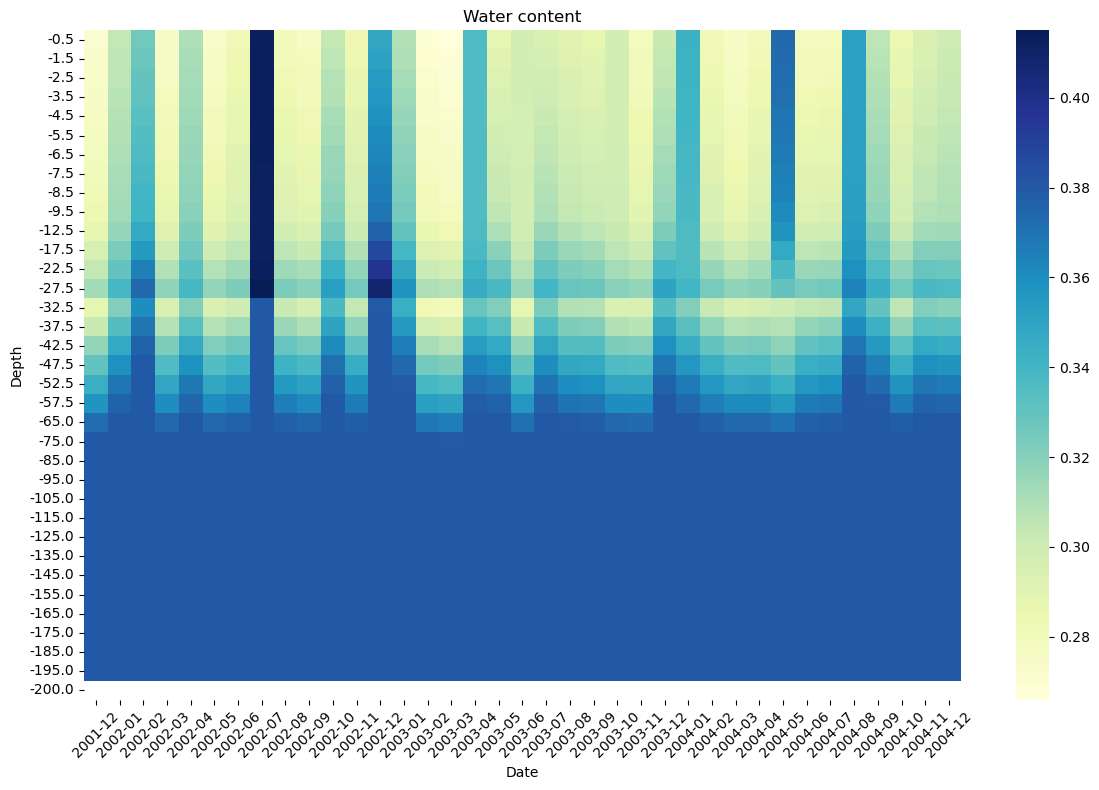

In [ ]:
from pyswap.core.plot.watercontent import plot_wcontent

plot_wcontent(result.vap)

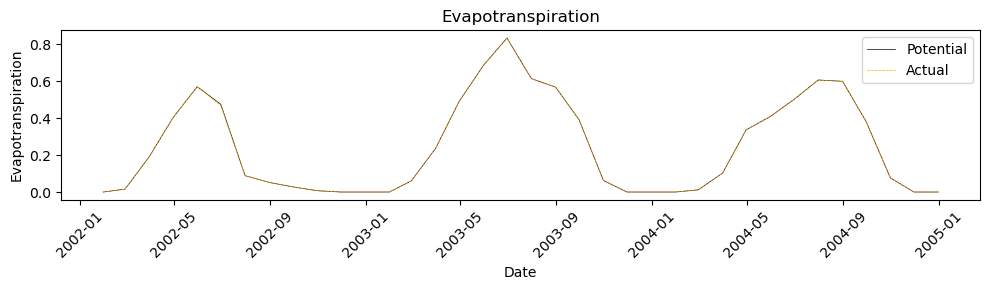

In [ ]:
from pyswap.core.plot.evapotranspiration import plot_evapotranspiration

plot_evapotranspiration(result.output.EPOT, result.output.EACT)


In [ ]:
import pandas as pd

df = pd.read_csv(result.vap, skiprows=13, delimiter=',', 
                 names=['date', 'depth', 'wcontent', 'phead', 'hconduc', 'drainage', 'rootext', 
                        'waterflux', 'temp', 'solute1', 'solute2', 'soluteflux', 'top', 'bottom', 'day', 'dcum'])

TypeError: argument of type 'method' is not iterable